In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

In [2]:
# Open the dataset file
raw_data = pd.read_csv('dataset_phishing.csv')
pd.set_option('display.max_columns', None)
raw_data.sample(5)

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
5843,http://nothingelsefilm.com/wp-content/themes/w...,73,19,0,1,1,0,0,0,0,0,0,0,0,8,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,1,1,0,0,0,0,0,8,1,2,15,2,15,15,10,6.875000,15.0,5.714286,4,0,0,0,0,0,0,0.000000,0.000000,0,0,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0.000000,0,0,1,1,0,0,1270,2381,0,0,1,2,phishing
7733,https://gerrard.doodlekit.com/home,34,21,0,2,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0.000000,0.0,0,0,0,0,0,2,0,0,1,0,3,0,3,2,4,7,4,9,9,4,6.666667,8.0,4.000000,0,0,0,0,0,0,13,0.692308,0.307692,0,0,0,0.0,0,0.0,0,1,75.0,0,0.0,100.0,0,0,0,0.000000,0,0,0,0,0,0,636,5208,24006,0,1,4,phishing
7533,https://www.brora.co.uk/,24,15,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,0,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,2,3,3,3,0,5,5,0,4.000000,4.0,0.000000,0,0,0,0,0,0,40,0.825000,0.175000,0,0,0,0.0,0,0.0,0,0,50.0,0,0.0,100.0,0,0,0,33.333333,0,0,0,0,0,0,762,8369,1212797,0,0,4,legitimate
2876,http://crackedtool.com/b/login.php?l=_JeHFUq_V...,162,15,1,6,1,0,1,3,0,2,3,0,0,4,0,1,0,0,0,0,0,0,0,0,1,0.265432,0.0,0,0,0,0,0,3,0,0,0,0,0,0,16,5,1,11,1,30,11,30,8.375000,11.0,8.200000,1,0,0,0,0,0,12,1.000000,0.000000,0,0,0,0.0,0,0.0,0,0,100.0,0,100.0,0.0,0,0,0,100.000000,0,0,0,1,1,0,190,-2,696261,0,1,3,phishing
7478,http://savageconquest.com/mailbox_upgrade/en.php,48,18,0,2,0,0,0,0,0,0,1,0,0,4,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,1,0,1,0,5,0,2,14,2,14,14,7,6.600000,14.0,4.750000,0,0,0,0,0,0,1,1.000000,0.000000,0,0,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0.000000,0,0,1,1,0,0,343,2943,0,0,1,1,phishing


In [3]:
# Check for missing (NAN) values in the columns
raw_data.isna().sum()

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64

In [4]:
# Remove columns that have the same value for all rows in the dataset
def remove_constant_columns(df):
    # Identify constant columns
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]
    print("Columns with constant values:", constant_columns)
    
    # Drop constant columns
    df_cleaned = df.drop(columns=constant_columns)
    
    # Print the number of columns in the cleaned DataFrame
    print("Number of remaining columns:", df_cleaned.shape[1])
    return df_cleaned
    
df_cleaned = remove_constant_columns(raw_data)

Columns with constant values: ['nb_or', 'ratio_nullHyperlinks', 'ratio_intRedirection', 'ratio_intErrors', 'submit_email', 'sfh']
Number of remaining columns: 83


<Axes: xlabel='status'>

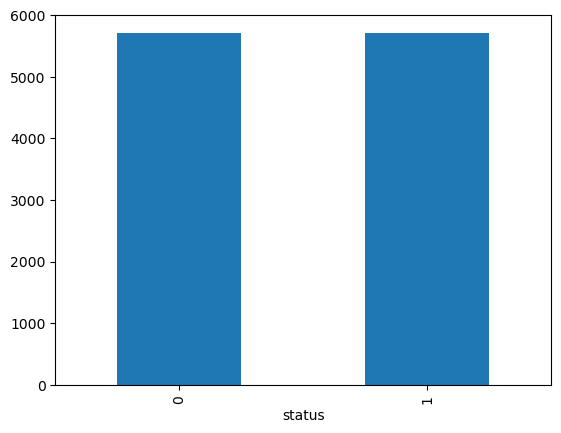

In [5]:
# Examine the features of the cleaned dataset.
features = df_cleaned.columns.tolist()
# Change the "status" column format from string to numeric(1/0) which will be used as a label to determine if the URL is phishing or not
df_cleaned['status'] = df_cleaned['status'].map({'phishing': 1, 'legitimate': 0})
# Check if the dataset is balanced - phishing urls count ?= legitimate urls count
df_cleaned['status'].value_counts().plot(kind='bar')

In [6]:
# Visualise the columns of the cleaned data
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 83 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_eq                       11430 non-null  int64  
 10  nb_underscore               11430 non-null  int64  
 11  nb_tilde                    11430 non-null  int64  
 12  nb_percent                  11430 non-null  int64  
 13  nb_slash                    114

In [7]:
# Select only the numerical columns from the dataframe (exclude the string type "url" column which is not a feature)
numerical_data = df_cleaned.select_dtypes(include=['float64', 'int64'])
# Compute the correlation matrix on the numerical columns
corr_matrix = numerical_data.corr()
# Track the corelations to the "status" column
status_corr = corr_matrix['status']
status_corr

length_url         0.248580
length_hostname    0.238322
ip                 0.321698
nb_dots            0.207029
nb_hyphens        -0.100107
                     ...   
web_traffic        0.060388
dns_record         0.122119
google_index       0.731171
page_rank         -0.511137
status             1.000000
Name: status, Length: 82, dtype: float64

In [8]:
# Function for selecting features that are above than threshold correlation with the "status" value 
def feature_selector_correlation(cmatrix, threshold):
    selected_features = []
    feature_score = []
    i=0
    for score in cmatrix:
        if abs(score)>threshold:
            selected_features.append(cmatrix.index[i])
            feature_score.append( ['{:3f}'.format(score)])
        i+=1
    result = list(zip(selected_features,feature_score))
    return result
    
selected_features = feature_selector_correlation(status_corr, 0.23)
selected_features = [feature for feature in selected_features if feature[0] != 'status']

print("Significant features that have a strong linear correlation with the status of the url (phishing or not) -",  len(selected_features), ":")
selected_features

Significant features that have a strong linear correlation with the status of the url (phishing or not) - 15 :


[('length_url', ['0.248580']),
 ('length_hostname', ['0.238322']),
 ('ip', ['0.321698']),
 ('nb_qm', ['0.294319']),
 ('nb_eq', ['0.233386']),
 ('nb_slash', ['0.242270']),
 ('nb_www', ['-0.443468']),
 ('ratio_digits_url', ['0.356395']),
 ('phish_hints', ['0.335393']),
 ('nb_hyperlinks', ['-0.342628']),
 ('ratio_intHyperlinks', ['-0.243982']),
 ('domain_in_title', ['0.342807']),
 ('domain_age', ['-0.331889']),
 ('google_index', ['0.731171']),
 ('page_rank', ['-0.511137'])]

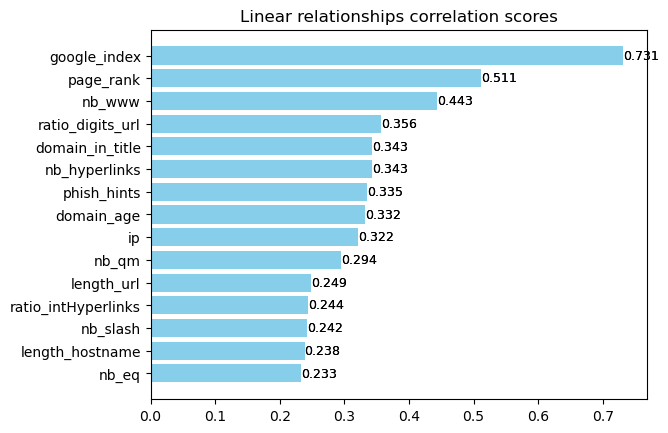

<Figure size 700x700 with 0 Axes>

In [9]:
# Visual representation of the feature selection based on linear correlation with the status
def plot_scores(scores, highlight_features=None):
    scores = scores.sort_values(ascending=True).head(15)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    for i, score in enumerate(scores):
        plt.text(score, i, f'{score:.3f}', va='center', ha='left', fontsize=9, color='black')
    # Loop over the scores to plot them
    for i, (score, feature) in enumerate(zip(scores, ticks)):
        # Color bars differently for features in the highlight list
        color = 'purple' if highlight_features and feature in highlight_features else 'skyblue'
        
        # Plot the bar with the appropriate color
        plt.barh(i, score, color=color)
        
        # Annotate the bars with the values
        plt.text(score, i, f'{score:.3f}', va='center', ha='left', fontsize=9, color='black')
    plt.yticks(width, ticks)
    plt.figure(dpi=100, figsize=(7,7))
    
scores = pd.Series({item[0]: float(item[1][0]) for item in selected_features})
absolute_linear_scores = scores.abs()
plt.title("Linear relationships correlation scores")
plot_scores(absolute_linear_scores)

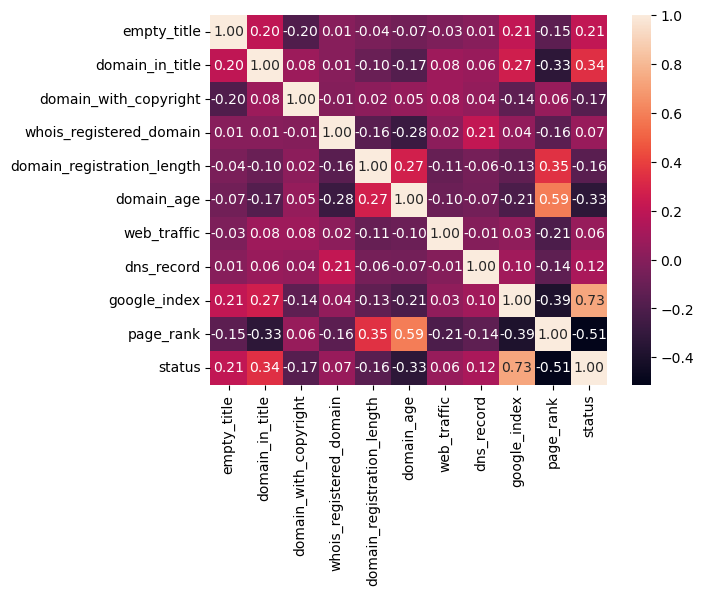

In [10]:
# Double check the selected columns correlation to the "status" column using the spearman's correlation matric heatmap
def corr_heatmap(data, idx_s, idx_e):
    y = data['status']
    temp = data.iloc[:, idx_s:idx_e]
    if 'url' in temp.columns:
        del temp['url']
    temp['status'] = y
    sns.heatmap(temp.corr(), annot=True, fmt='.2f')
    plt.show()
    
corr_heatmap(df_cleaned, 72, 82)

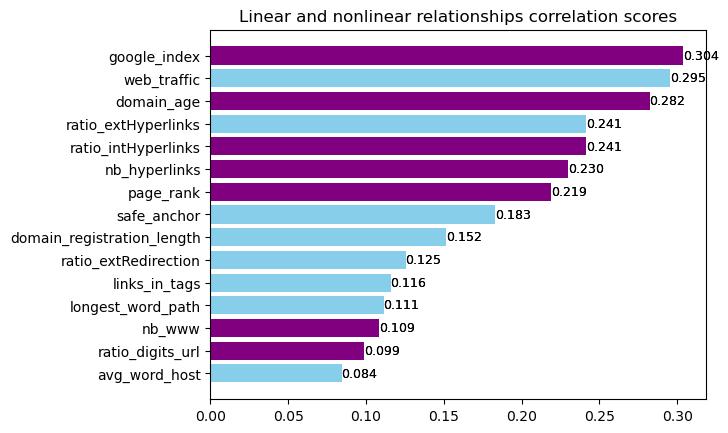

<Figure size 700x700 with 0 Axes>

In [11]:
# Using only linear relationships correlation might not be very accurate way to select the most important features.
# Using the function sklearn's mutual_info_classif function is especially designed to solve this selection task based on both linear and nonlinear relationships in the data.
from sklearn.feature_selection import mutual_info_classif

X = df_cleaned.drop(['url', 'status'], axis=1)
Y = df_cleaned['status']

discrete_features = X.dtypes == int
mi_scores = mutual_info_classif(X, Y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

absolute_linear_scores_names = absolute_linear_scores.index.tolist()

plt.title("Linear and nonlinear relationships correlation scores")
plot_scores(mi_scores.head(15), highlight_features=absolute_linear_scores_names)

In [12]:
# Update the features for model training to contain only the top 15 mutual info top scored features.
top_mi_scored_features_names = mi_scores.head(15).index.tolist()
X = df_cleaned[top_mi_scored_features_names] 

In [13]:
# Import the models Naive Bayes, KNN, LogisticRegression, RandomForestClassifier, MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [14]:
# transform the dataset in appropriate format for model training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=41)

# Without scaling, features with larger ranges (e.g., length_url) might dominate the model,
# while features with smaller ranges (e.g., google_index) might be ignored.
# By scaling, all features receive equal opportunity to influence the model.
scaler = StandardScaler()
# The test data is scaled using the mean and standard deviation derived from the training set only
X_train_scaled = scaler.fit_transform(X_train)
# The test set remains unseen during training
X_test_scaled = scaler.transform(X_test)

# Initiate the models
classifiers = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(verbose=True),
    'Random Forest': RandomForestClassifier(verbose=True),
    'MLP Classifier': MLPClassifier(verbose=True)
}
# Set different hyperparameter configurations for each model so that the best is picked up by GridSearchCV
param_grids = {
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'p': [1, 2, 3]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20]
    },
    'MLP Classifier': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam'],
        'max_iter': [500, 1000],
        'learning_rate_init': [0.001, 0.0005],
        'early_stopping': [True]
    }
}

In [15]:
# Train all models with the different hyperparameters
trained_models = {}
training_times = {}  # Dictionary to store training times

start_time = datetime.now()
print(f"Training started at: {start_time.strftime('%H:%M:%S')}")

for name, clf in classifiers.items():
    model_start_time = datetime.now()
    print(f"{name} training started at: {model_start_time.strftime('%H:%M:%S')}")
    
    # Train the model
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grids[name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_scaled, Y_train)
    trained_models[name] = grid_search
    
    model_end_time = datetime.now()
    print(f"{name} training finished at: {model_end_time.strftime('%H:%M:%S')}")
    
    # Calculate and store training time
    duration = (model_end_time - model_start_time).total_seconds()
    training_times[name] = duration

end_time = datetime.now()
print(f"Training finished at: {end_time.strftime('%H:%M:%S')}")

Training started at: 15:52:08
Naive Bayes training started at: 15:52:08
Naive Bayes training finished at: 15:52:10
KNN training started at: 15:52:10
KNN training finished at: 15:52:31
Logistic Regression training started at: 15:52:31
Logistic Regression training finished at: 15:52:32
Random Forest training started at: 15:52:32


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.6s


Random Forest training finished at: 15:53:11
MLP Classifier training started at: 15:53:11
Iteration 1, loss = 0.52717174
Validation score: 0.906760
Iteration 2, loss = 0.27177824
Validation score: 0.920746
Iteration 3, loss = 0.21584273
Validation score: 0.928904
Iteration 4, loss = 0.20445057
Validation score: 0.933566
Iteration 5, loss = 0.19835360
Validation score: 0.932401
Iteration 6, loss = 0.19346657
Validation score: 0.933566
Iteration 7, loss = 0.18974791
Validation score: 0.935897
Iteration 8, loss = 0.18659246
Validation score: 0.935897
Iteration 9, loss = 0.18367623
Validation score: 0.935897
Iteration 10, loss = 0.18048001
Validation score: 0.934732
Iteration 11, loss = 0.17761961
Validation score: 0.935897
Iteration 12, loss = 0.17551885
Validation score: 0.932401
Iteration 13, loss = 0.17204664
Validation score: 0.930070
Iteration 14, loss = 0.17002232
Validation score: 0.934732
Iteration 15, loss = 0.16759910
Validation score: 0.933566
Iteration 16, loss = 0.16695007
Va

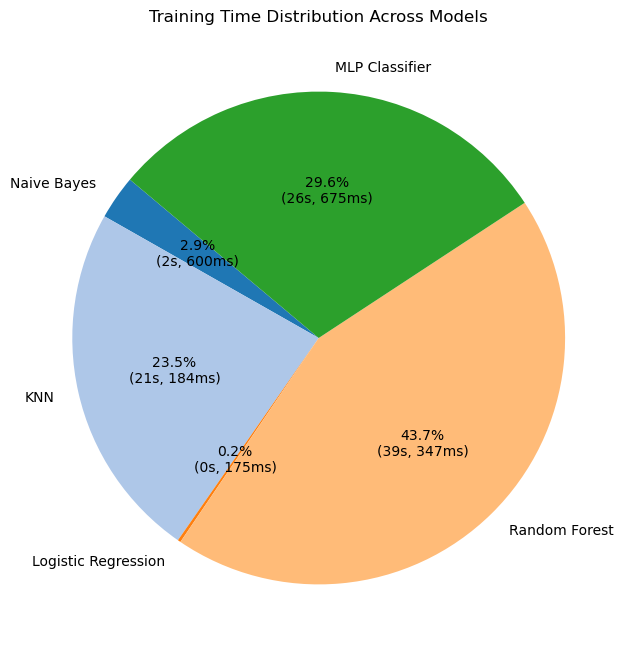

In [16]:
# Plot the pie chart
plt.figure(figsize=(8, 8))
labels = training_times.keys()
values = training_times.values()

def autopct_format(pct, all_values):
    total = sum(all_values)
    raw_value = pct * total / 100
    seconds = int(raw_value)  # Extract seconds
    milliseconds = int((raw_value - seconds) * 1000)  # Extract milliseconds
    return f"{pct:.1f}%\n({seconds}s, {milliseconds}ms)"

plt.pie(values, labels=labels, autopct=lambda pct: autopct_format(pct, values), startangle=140, colors=plt.cm.tab20.colors)
plt.title("Training Time Distribution Across Models")
plt.show()

In [17]:
# Print the training results for each model
for name, grid_search in trained_models.items():
    print(f"{name}:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    best_model = grid_search.best_estimator_
    Y_pred = best_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(Y_test, Y_pred)
    print("Test Accuracy:", test_accuracy)
    print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
    print("Classification Report:\n", classification_report(Y_test, Y_pred))
    print()

Naive Bayes:
Best Parameters: {'var_smoothing': 1e-09}
Best Score: 0.9020071372439624
Test Accuracy: 0.907627711686494
Confusion Matrix:
 [[1278  101]
 [ 163 1316]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      1379
           1       0.93      0.89      0.91      1479

    accuracy                           0.91      2858
   macro avg       0.91      0.91      0.91      2858
weighted avg       0.91      0.91      0.91      2858


KNN:
Best Parameters: {'n_neighbors': 3, 'p': 1}
Best Score: 0.9359537473932731
Test Accuracy: 0.9415675297410777
Confusion Matrix:
 [[1290   89]
 [  78 1401]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1379
           1       0.94      0.95      0.94      1479

    accuracy                           0.94      2858
   macro avg       0.94      0.94      0.94      2858
weighted avg       0.94    

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [18]:
# Print the best version of each model type + the hyperparameters that achieve it
print("Summary of Best Models:")
for name, grid_search in trained_models.items():
    print(f"{name}:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score (CV):", grid_search.best_score_)
    print()

Summary of Best Models:
Naive Bayes:
Best Parameters: {'var_smoothing': 1e-09}
Best Score (CV): 0.9020071372439624

KNN:
Best Parameters: {'n_neighbors': 3, 'p': 1}
Best Score (CV): 0.9359537473932731

Logistic Regression:
Best Parameters: {'C': 1}
Best Score (CV): 0.9189209085868052

Random Forest:
Best Parameters: {'max_depth': 20, 'n_estimators': 300}
Best Score (CV): 0.9524028154352255

MLP Classifier:
Best Parameters: {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001, 'max_iter': 1000, 'solver': 'adam'}
Best Score (CV): 0.9311715898227936



Recap for the Naive Bayes model:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      1379
           1       0.93      0.89      0.91      1479

    accuracy                           0.91      2858
   macro avg       0.91      0.91      0.91      2858
weighted avg       0.91      0.91      0.91      2858

Precision: 0.91
Recall: 0.91
F1 Score: 0.91
Accuracy: 0.91


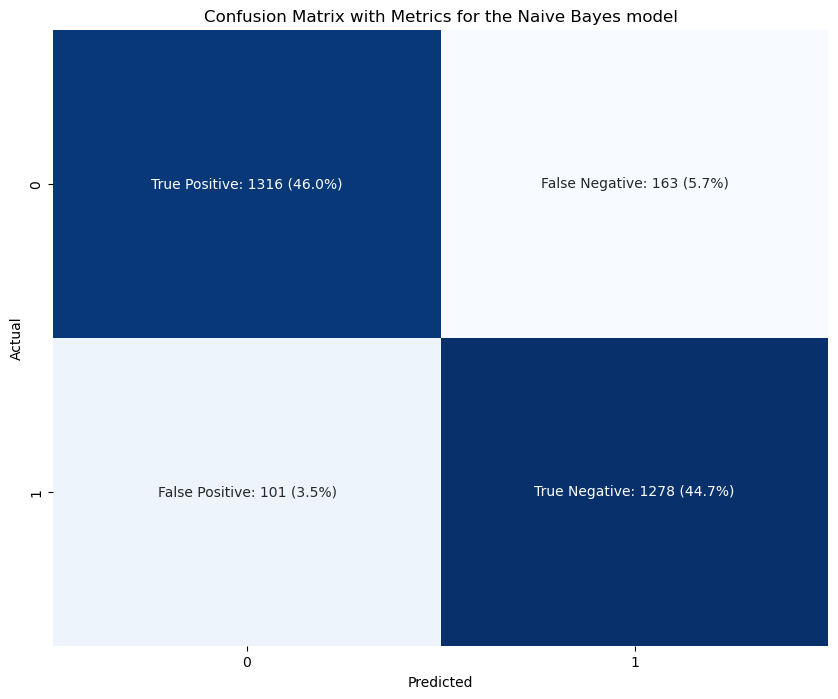


Recap for the KNN model:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1379
           1       0.94      0.95      0.94      1479

    accuracy                           0.94      2858
   macro avg       0.94      0.94      0.94      2858
weighted avg       0.94      0.94      0.94      2858

Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Accuracy: 0.94


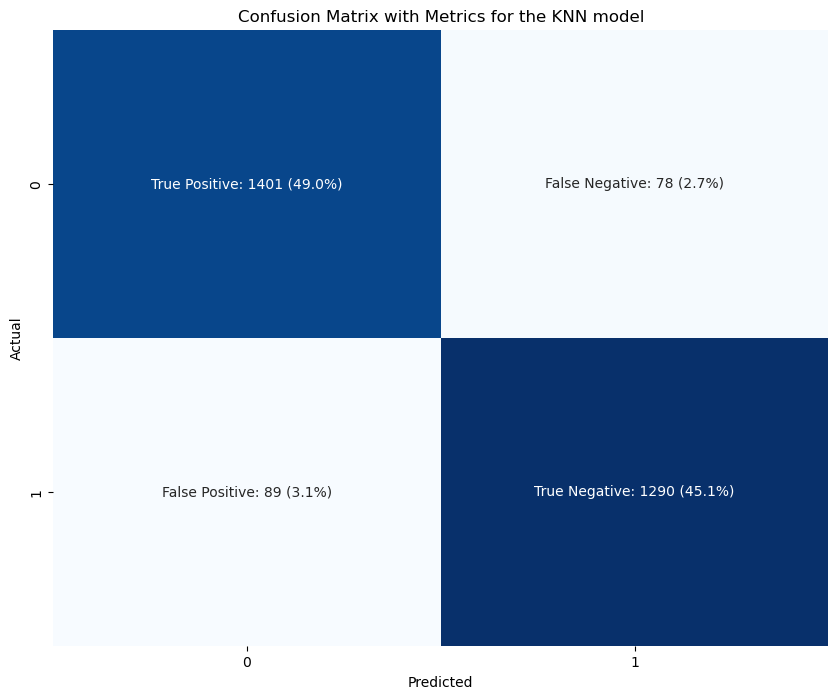


Recap for the Logistic Regression model:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      1379
           1       0.93      0.92      0.92      1479

    accuracy                           0.92      2858
   macro avg       0.92      0.92      0.92      2858
weighted avg       0.92      0.92      0.92      2858

Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Accuracy: 0.92


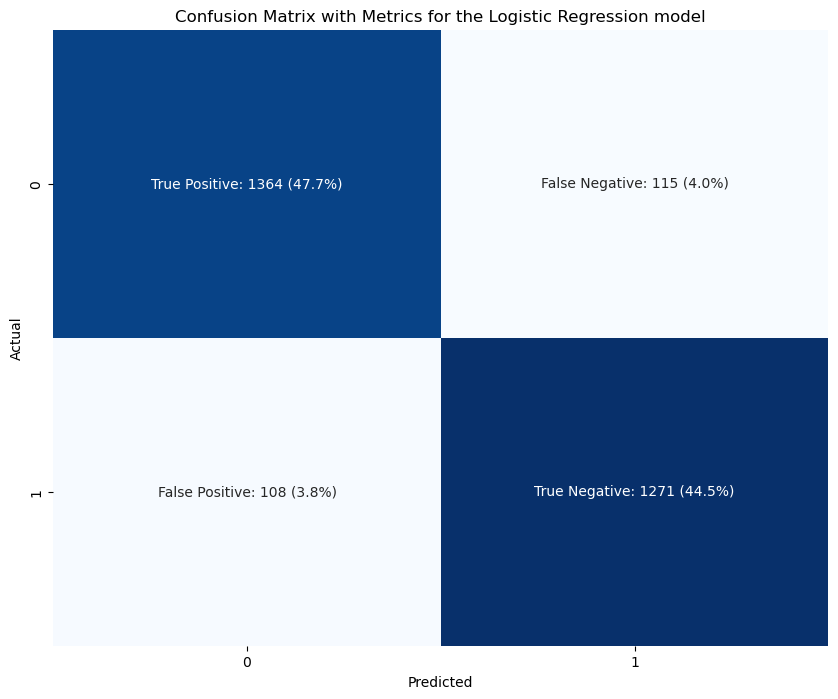


Recap for the Random Forest model:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      1379
           1       0.97      0.96      0.96      1479

    accuracy                           0.96      2858
   macro avg       0.96      0.96      0.96      2858
weighted avg       0.96      0.96      0.96      2858

Precision: 0.96
Recall: 0.96
F1 Score: 0.96
Accuracy: 0.96


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


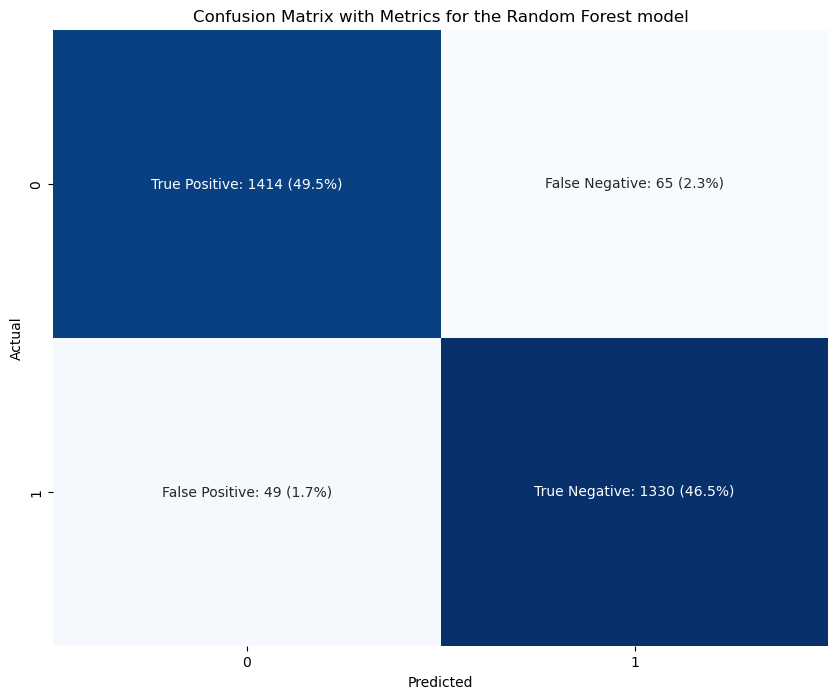


Recap for the MLP Classifier model:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      1379
           1       0.94      0.94      0.94      1479

    accuracy                           0.94      2858
   macro avg       0.94      0.94      0.94      2858
weighted avg       0.94      0.94      0.94      2858

Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Accuracy: 0.94


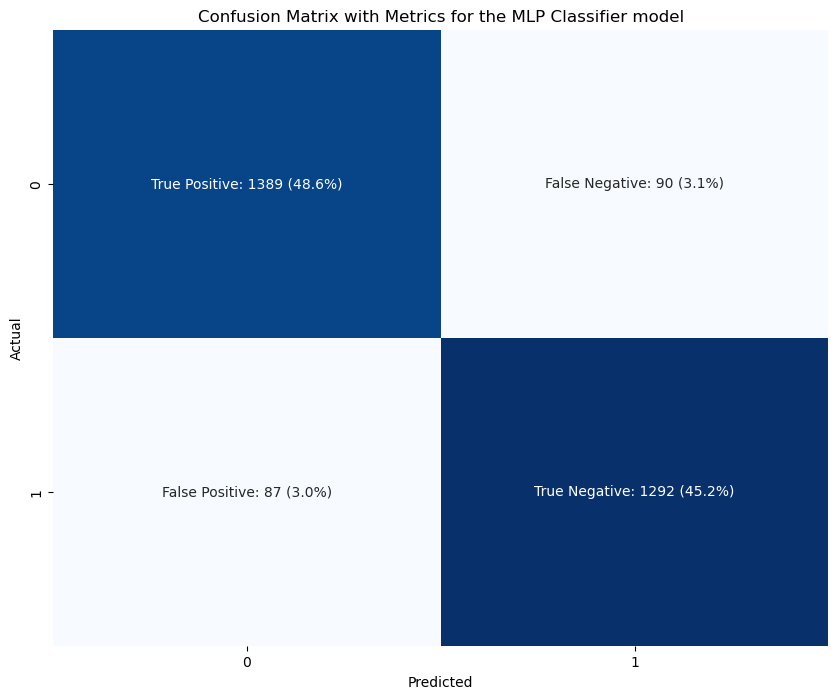

In [19]:
# Visualise the confusion matrix + stats for each model type
for name, grid_search in trained_models.items():
    Y_pred = grid_search.predict(X_test_scaled)
    print("Recap for the " + name + " model:\n", classification_report(Y_test, Y_pred))
    
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred, output_dict=True)
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    
    annotations = np.empty_like(conf_matrix, dtype=object)
    total = conf_matrix.sum()
    tn, fp, fn, tp = conf_matrix.ravel()
    annotations[0, 0] = f"True Positive: {tp} ({tp / total * 100:.1f}%)"
    annotations[1, 0] = f"False Positive: {fp} ({fp / total * 100:.1f}%)"
    annotations[0, 1] = f"False Negative: {fn} ({fn / total * 100:.1f}%)"
    annotations[1, 1] = f"True Negative: {tn} ({tn / total * 100:.1f}%)"

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=annotations, fmt="", cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix with Metrics for the ' + name + " model")
    plt.show()
    print()

In [20]:
# Test the models on example urls we would see in the real life to examine their performance outside of the dataset field
# Rough example feature extraction function is used (NOT accurate, made up just for testing and development purposes)
def extract_features(url):
    from urllib.parse import urlparse
    import re
    
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path

    features = {}
    # Normally obtained from a web database (e.g., Google Search indexing status)
    features['google_index'] = 10 if "google.com" in domain else 0
    # Normally based on Alexa rankings or web traffic analytics - real sites get higher traffic
    features['web_traffic'] = len(url) * 5
    # Normally obtained from WHOIS lookup for domain registration date - older domains are likely to be real
    features['domain_age'] = 10 if ".com" in domain else 3
    # Ratio of external hyperlinks; for simplicity, assumed proportion of '/' in path - phishing URLs often have more slashes
    features['ratio_extHyperlinks'] = path.count('/') / len(url) if len(url) > 0 else 0
    # Ratio of internal hyperlinks; derived as a proxy from domain complexity - legitimate domains often have fewer dots in the domain
    features['ratio_intHyperlinks'] = domain.count('.') / len(url) if len(url) > 0 else 0
    # Number of hyperlinks inferred from slashes and dots - phishing URLs might have many slashes and dots to appear legitimate
    features['nb_hyperlinks'] = url.count('/') + url.count('.')
    # PageRank values are normally computed via web crawlers or PageRank API - real websites tend to have higher PageRank
    features['page_rank'] = 0.9 if domain.endswith((".com", ".org")) else 0.2
    # Anchors containing safe keywords (secure, safe, verification, etc.) - phishing URLs might use misleading safe-sounding keywords
    features['safe_anchor'] = 1 if re.search(r'(?i)\b(safe|secure|verification)\b', path) else 0
    # Normally from WHOIS database for domain expiration date - legitimate domains are registered for longer periods
    features['domain_registration_length'] = 3650 if domain.endswith(".com") else 365
    # Depth of path determined by the number of '/' in the path - phishing URLs often have deeper paths to mimic real URLs
    features['links_in_tags'] = len(path.split('/')) - 1
    # Detects redirections based on "redirect" keyword in URL - phishing URLs often include redirection in their names
    features['ratio_extRedirection'] = 1 if "redirect" in url else 0
    # Finds the longest word in the URL path - phishing URLs might have unusual long words to confuse users
    features['longest_word_path'] = max([len(word) for word in path.split('/') if word], default=0)
    # Counts occurrences of 'www' in the domain - phishing URLs might misuse subdomains
    features['nb_www'] = domain.count('www')
    # Ratio of numeric characters in the URL - phishing URLs often include numbers to mimic legitimate ones
    features['ratio_digits_url'] = sum(c.isdigit() for c in url) / len(url) if len(url) > 0 else 0
    # Error-related terms in the URL
    features['ratio_extErrors'] = 0.5 if "error" in url else 0
    return list(features.values())

# Transform URLs into feature vectors first
real_features = [extract_features(url) for url in ["https://www.youtube.com/", "https://www.microsoft.com/en-us", 
                                                   "https://www.amazon.com", "https://www.wikipedia.org", 
                                                   "https://www.paypal.com"]]
phishing_features = [extract_features(url) for url in [ "http://secure-go0gle-login.verification.com",  # Mimics Google login
                                                        "https://microsoft-update.support-login.info",  # Mimics Microsoft support
                                                         "http://amz-login-services.xyz",               # Mimics Amazon services
                                                         "https://paypal-secure-check.xyz",             # Mimics PayPal secure login
                                                         "http://account-verification-paypall.net"]]    # Mimics PayPal account verification

# Scale the feature vectors
real_features_scaled = scaler.transform(real_features)
phishing_features_scaled = scaler.transform(phishing_features)

# Use the trained models for predictions
for name, grid_search in trained_models.items():
    real_addresses_pred = grid_search.predict(real_features_scaled)
    phishing_addresses_pred = grid_search.predict(phishing_features_scaled)
    
    print(f"Predictions for {name} model:")
    print("Real addresses:", real_addresses_pred)
    print("Phishing addresses:", phishing_addresses_pred)
    print()

Predictions for Naive Bayes model:
Real addresses: [0 0 0 0 0]
Phishing addresses: [0 1 1 1 1]

Predictions for KNN model:
Real addresses: [0 0 0 0 0]
Phishing addresses: [1 1 1 1 1]

Predictions for Logistic Regression model:
Real addresses: [0 0 0 0 0]
Phishing addresses: [1 1 1 1 1]

Predictions for Random Forest model:
Real addresses: [0 0 0 0 0]
Phishing addresses: [1 1 1 1 1]

Predictions for MLP Classifier model:
Real addresses: [0 0 0 0 0]
Phishing addresses: [1 1 1 1 1]



E:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
E:\Anaconda\envs\tf-gpu\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [ ]:
models = ['Naive Bayes', 'KNN', 'Logistic Regression', 'Random Forest', 'Neural Network']
precision = [0.91, 0.94, 0.92, 0.96, 0.94]
recall = [0.91, 0.94, 0.92, 0.96, 0.94]
f1_score = [0.91, 0.94, 0.92, 0.96, 0.94]
accuracy = [0.91, 0.94, 0.92, 0.96, 0.94]

x = np.arange(len(models))  
width = 0.2  

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width*1.5, precision, width, label='Precision')
rects2 = ax.bar(x - width/2, recall, width, label='Recall')
rects3 = ax.bar(x + width/2, f1_score, width, label='F1 Score')
rects4 = ax.bar(x + width*1.5, accuracy, width, label='Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Metrics comparrison for different models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()